### Cohort Analysis

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Connect to the BigQuery API
from googleapiclient.discovery import build
from oauth2client import client
credentials = client._get_application_default_credential_from_file('crowd-power-192c6ece53ed.json')
credentials = credentials.create_scoped('https://www.googleapis.com/auth/bigquery')
bigquery_service = build('bigquery', 'v2', credentials=credentials)

In [9]:
# Run a SQL query against the HITgroup data
# to find out the dates of first and last activity
# for each requester. Then, aggregate on top,
# and report the number of requesters that were firstSeen
# on a month X, and were lastSeen on a month Y
#
# The string manipulation is just to get the dates
# represented as YYYY-MM
query_request = bigquery_service.jobs()
query_data = {
    'query': (
        '''
SELECT
  firstSeen,
  lastSeen,
  COUNT(*) AS cnt,
  SUM(HITgroupsPosted) AS hits 
FROM (
  SELECT
    requesterId,
    STRING(YEAR(MIN(firstSeen))) + '-' + RIGHT('0' + STRING(MONTH(MIN(firstSeen))), 2) AS firstSeen,
    STRING(YEAR(MAX(lastSeen))) + '-' + RIGHT('0' + STRING(MONTH(MAX(lastSeen))), 2) AS lastSeen,
    COUNT(groupId) AS HITgroupsPosted
  FROM
    entities.HITgroup
  GROUP BY
    requesterId)
GROUP BY
  firstSeen,
  lastSeen
ORDER BY
  firstSeen,
  lastSeen
        ''')
}

query_response = query_request.query(
            projectId='crowd-power',
            body=query_data).execute()

# Put the SQL results in a Pandas Dataframe
import pandas as pd
columns = [f.get('name') for f in query_response['schema']['fields']]
rows = [tuple([row['f'][i]['v'] for i in range(len(row['f']))]) for row in query_response['rows']]
df = pd.DataFrame(data=rows, columns=columns, dtype=int)
df.to_csv("cohort-analysis.csv")
# Transform the dataframe into a table with lastSeen month as rows and firstSeen month as columns
pivot = pd.pivot_table(df, values='cnt', index=['lastSeen'], columns=['firstSeen'])


In [10]:
# We will do a set of transformations here, to create a pivotTable
# with each column containing a cohort of users, and each row
# showing how many requesters from that cohort are still active
# (active means that they have posted a HIT on that month or later)
import numpy as np

# The cumulative sum creates columns that have the "opposite" order
# than what we want
pc = pivot.cumsum()
# Ideally, I would like to "reverse" the columns ignoring NaNs
# but I cannot figure out an easy way to do so. So, I revert 
# to a set of for loops. The 
pc2 = pd.DataFrame(pivot)
for c in pc.columns.values:
    pc2[c] = np.amax(pc,axis=0)[c] - pc[c].shift() 
for c in pc.columns.values:
    pc2.at[c,c] = np.amax(pc,axis=0)[c]
    
pc2

firstSeen,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,...,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02
lastSeen,,,,,,,,,,,,,,,,,,,,,
2014-05,2677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06,1795,1592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07,1540,934,1512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08,1432,743,804,1301,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09,1340,678,605,619,1076,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10,1272,631,536,468,515,1227,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11,1228,599,492,425,382,605,1342,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12,1169,574,468,394,348,443,583,855,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01,1134,558,447,370,325,401,433,394,987,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


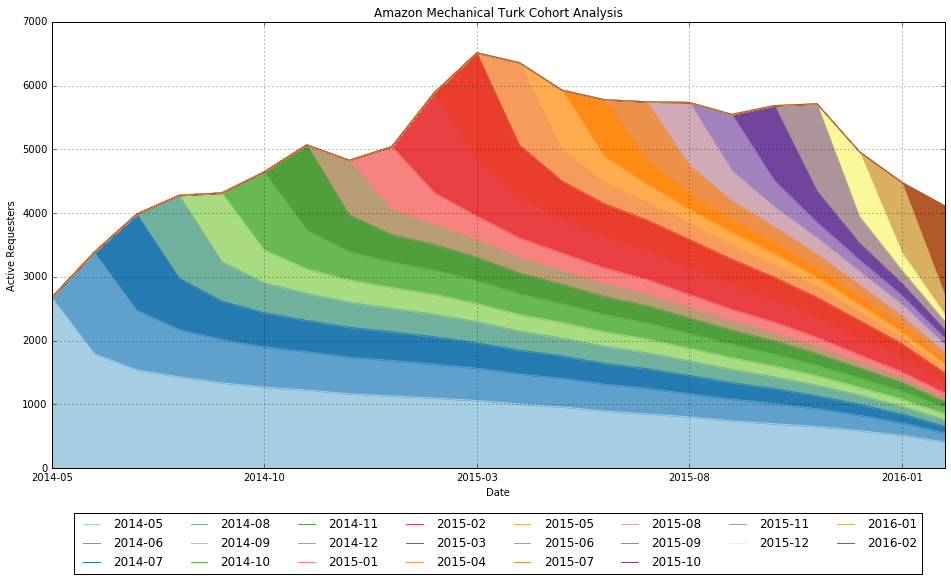

In [6]:
f = plt.figure(edgecolor='k')
ax=f.gca()
pc2.plot(kind='area', stacked=True, legend=True, figsize=(16,8), cmap='Paired', grid=True, ax=ax);

plt.title('Amazon Mechanical Turk Cohort Analysis', color='black')
plt.legend(loc='lower center', ncol=8, bbox_to_anchor=[0.5, -0.25])
ax.set_ylabel("Active Requesters")
ax.set_xlabel("Date")
plt.show()

f.savefig('mturk-cohort-analysis.png', bbox_inches='tight')